In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
torch.manual_seed(55)

# define model

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.dense1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.dense2 = nn.Linear(in_features=120,out_features=84)
        self.dense3 = nn.Linear(in_features=84, out_features=10)
        
    def flattened_features(self, x):
        # faltten everything except for first (batch) dimension
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x,2)
        x = x.view(-1, self.flattened_features(x))
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x

        

In [18]:
class LeNet_max(nn.Module):
    def __init__(self):
        super(LeNet_max,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.dense1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.dense2 = nn.Linear(in_features=120,out_features=84)
        self.dense3 = nn.Linear(in_features=84, out_features=10)
        
    def flattened_features(self, x):
        # faltten everything except for first (batch) dimension
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = torch.flatten(x,1)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x


In [4]:
# check model structure
lenet = LeNet()
lenet.cuda()
print(lenet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=400, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense3): Linear(in_features=84, out_features=10, bias=True)
)


# Training and Testing routine

In [3]:
def train(net, trainloader, optim, epoch, device):
    # initialize loss
    loss_total = 0.0
    for i, (X,y) in enumerate(trainloader, 0): # i starts with 0
        X, y = X.to(device), y.to(device)
        optim.zero_grad() # zero the parameter gradients
        output = net(X)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output,y)
        loss.backward()
        optim.step()
        
        # update loss
        loss_total += loss.item()
        
        # print every 1000 batches
        if (i+1) % 1000 == 0:
            print("[Epoch number: %d, Mini-batches: %5d] loss: %.3f" % (epoch+1,i+1,loss_total/200))
            loss_total = 0
    

In [4]:
def test(net, testloader, device):
    success = 0
    counter = 0
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            output = net(X)
            _,pred = torch.max(output.data,1)
            counter += y.size(0)
            success += (pred == y).sum().item()
    print("LeNet accuracy on 10000 images from test dataset: %d %%" % (100*success/counter))

# load Images

In [5]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomCrop(32,4),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root="W://Study Material/Jupyter Notebook/Datasets/CIFAR-10",
                                       train=True,download=False,transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=8,shuffle=True,num_workers=1)

test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
testset = torchvision.datasets.CIFAR10(root="W://Study Material/Jupyter Notebook/Datasets/CIFAR-10",
                                      train=False,download=False,transform=test_transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=10000,shuffle=False,num_workers=2)

classes = ("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")

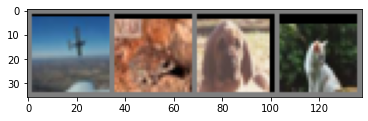

        plane  ||   frog  ||   dog  ||   cat


In [6]:
# define function that displays an image

def imageshow(image):
    # un-nomalize the image
    image = image/2 + 0.5
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage,(1,2,0)))
    plt.show()

# extract image from training set
dataiter = iter(trainloader)
images, labels = dataiter.next()

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))

# print labels
print(" "*8 + "  ||   ".join(classes[labels[j]] for j in range(num_images)))

# training

In [21]:
# this is for using average pooling 
lenet = LeNet()
lenet.cuda()
optim = torch.optim.Adam(lenet.parameters(),lr=0.05)
device = torch.device("cuda")

for epoch in range(3):
    train(lenet, trainloader, optim, epoch, device)
    print()
    test(lenet, testloader, device)
    print()
print("Finished training!")

[Epoch number: 1, Mini-batches:  1000] loss: 12.106
[Epoch number: 1, Mini-batches:  2000] loss: 11.572
[Epoch number: 1, Mini-batches:  3000] loss: 11.590
[Epoch number: 1, Mini-batches:  4000] loss: 11.577
[Epoch number: 1, Mini-batches:  5000] loss: 11.579
[Epoch number: 1, Mini-batches:  6000] loss: 11.583

LeNet accuracy on 10000 images from test dataset: 10 %

[Epoch number: 2, Mini-batches:  1000] loss: 11.589
[Epoch number: 2, Mini-batches:  2000] loss: 11.574
[Epoch number: 2, Mini-batches:  3000] loss: 11.584
[Epoch number: 2, Mini-batches:  4000] loss: 11.572
[Epoch number: 2, Mini-batches:  5000] loss: 11.573
[Epoch number: 2, Mini-batches:  6000] loss: 11.586

LeNet accuracy on 10000 images from test dataset: 10 %

[Epoch number: 3, Mini-batches:  1000] loss: 11.577
[Epoch number: 3, Mini-batches:  2000] loss: 11.578
[Epoch number: 3, Mini-batches:  3000] loss: 11.573
[Epoch number: 3, Mini-batches:  4000] loss: 11.585
[Epoch number: 3, Mini-batches:  5000] loss: 11.576
[E

In [7]:
# some experiment showed that the learning rate was too high
lenet = LeNet()
lenet.cuda()
optim = torch.optim.Adam(lenet.parameters(),lr=0.001)
device = torch.device("cuda")

for epoch in range(3):
    train(lenet, trainloader, optim, epoch, device)
    print()
    test(lenet, testloader, device)
    print()
print("Finished training!")

[Epoch number: 1, Mini-batches:  1000] loss: 9.884
[Epoch number: 1, Mini-batches:  2000] loss: 8.815
[Epoch number: 1, Mini-batches:  3000] loss: 8.413
[Epoch number: 1, Mini-batches:  4000] loss: 8.159
[Epoch number: 1, Mini-batches:  5000] loss: 7.992
[Epoch number: 1, Mini-batches:  6000] loss: 7.823

LeNet accuracy on 10000 images from test dataset: 46 %

[Epoch number: 2, Mini-batches:  1000] loss: 7.543
[Epoch number: 2, Mini-batches:  2000] loss: 7.530
[Epoch number: 2, Mini-batches:  3000] loss: 7.388
[Epoch number: 2, Mini-batches:  4000] loss: 7.448
[Epoch number: 2, Mini-batches:  5000] loss: 7.296
[Epoch number: 2, Mini-batches:  6000] loss: 7.288

LeNet accuracy on 10000 images from test dataset: 52 %

[Epoch number: 3, Mini-batches:  1000] loss: 7.134
[Epoch number: 3, Mini-batches:  2000] loss: 7.120
[Epoch number: 3, Mini-batches:  3000] loss: 6.978
[Epoch number: 3, Mini-batches:  4000] loss: 6.966
[Epoch number: 3, Mini-batches:  5000] loss: 6.990
[Epoch number: 3, M

In [23]:
# save model
model_path = "W://Study Material/Jupyter Notebook/Small Projects/CIFAR-10 - PyTorch./LeNet_model.pth"
torch.save(lenet.state_dict(),model_path)

In [8]:
# continuing training with even lower training rate
optim = torch.optim.Adam(lenet.parameters(),lr=0.0005)
for epoch in range(10):
    train(lenet, trainloader, optim, epoch, device)
    print()
    test(lenet, testloader, device)
    print()
print("Finished training!")

[Epoch number: 1, Mini-batches:  1000] loss: 6.447
[Epoch number: 1, Mini-batches:  2000] loss: 6.384
[Epoch number: 1, Mini-batches:  3000] loss: 6.425
[Epoch number: 1, Mini-batches:  4000] loss: 6.476
[Epoch number: 1, Mini-batches:  5000] loss: 6.437
[Epoch number: 1, Mini-batches:  6000] loss: 6.322

LeNet accuracy on 10000 images from test dataset: 57 %

[Epoch number: 2, Mini-batches:  1000] loss: 6.184
[Epoch number: 2, Mini-batches:  2000] loss: 6.270
[Epoch number: 2, Mini-batches:  3000] loss: 6.261
[Epoch number: 2, Mini-batches:  4000] loss: 6.293
[Epoch number: 2, Mini-batches:  5000] loss: 6.128
[Epoch number: 2, Mini-batches:  6000] loss: 6.174

LeNet accuracy on 10000 images from test dataset: 59 %

[Epoch number: 3, Mini-batches:  1000] loss: 6.110
[Epoch number: 3, Mini-batches:  2000] loss: 6.111
[Epoch number: 3, Mini-batches:  3000] loss: 6.164
[Epoch number: 3, Mini-batches:  4000] loss: 6.014
[Epoch number: 3, Mini-batches:  5000] loss: 5.958
[Epoch number: 3, M

In [25]:
torch.save(lenet.state_dict(),model_path)

# Test

In [11]:
# load model
lenet2 = LeNet()
lenet2.cuda()
model_path = "W://Study Material/Jupyter Notebook/Small Projects/CIFAR-10 - PyTorch./LeNet_model.pth"
lenet2.load_state_dict(torch.load(model_path))
print(lenet2)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=400, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense3): Linear(in_features=84, out_features=10, bias=True)
)


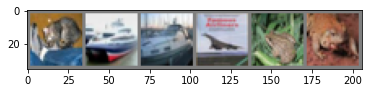

Label:           cat   ship   ship  plane   frog   frog
Prediction:       cat    car   ship  plane   frog   frog


In [28]:
# load test dataset images
testbatchs = iter(testloader)
X, y = next(testbatchs)

# show iamges and labels
imageshow(torchvision.utils.make_grid(X[:6]))
X, y = X.to("cuda"), y.to("cuda")
print("Label:        ", "  ".join("%5s" % classes[y[j]] for j in range(6)))

# making model inference
prediction = lenet(X)
_, pred = torch.max(prediction, 1)
print("Prediction:    ", "  ".join("%5s" % classes[pred[j]] for j in range(6)))

In [9]:
test(lenet, testloader, device)

LeNet accuracy on 10000 images from test dataset: 63 %


In [12]:
test(lenet2, testloader, device)

LeNet accuracy on 10000 images from test dataset: 63 %


In [13]:
# check overall accuracy
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        X, y = data
        X, y = X.to("cuda"), y.to("cuda")
        prediction = lenet(X)
        pred_max_val, pred_max_idx = torch.max(prediction, 1)
        counter += y.size()[0]
        success += (pred_max_idx==y).sum().item()
print("Model accuracy on 10000 images from test dataset: %d%%" %(100*success/counter))


Model accuracy on 10000 images from test dataset: 63%


In [16]:
# per class accuracy
class_success = list(0. for i in range(10))
class_counter = list(0. for i in range(10))

k = (pred_max_idx == y).squeeze()
for i in range(10000):
    label = y[i]
    class_success[label] += k[i].item()
    class_counter[label] += 1

for i in range(10):
    print(f"Model accuracy for class {classes[i]}:  {100*class_success[i]/class_counter[i]}%")

        


Model accuracy for class plane:  70.1%
Model accuracy for class car:  82.1%
Model accuracy for class bird:  58.6%
Model accuracy for class cat:  34.1%
Model accuracy for class deer:  49.0%
Model accuracy for class dog:  48.2%
Model accuracy for class frog:  82.4%
Model accuracy for class horse:  62.0%
Model accuracy for class ship:  77.3%
Model accuracy for class truck:  71.7%
